In [128]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.dummy import DummyRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV

In [100]:
FILE = '../Сводная вегетация.xlsx'
YEARS = [2012, 2013, 2014, 2015, 2016]

## Building a table of data

In [101]:
def get_year_culture_week_ndvi():
    data = pd.DataFrame(columns = ['year', 'culture', 'week', 'ndvi'])
    
    for year in YEARS:
        df = pd.read_excel(FILE, sheetname=str(year), header=1)

        ndvi_columns = [col for col in df.columns if 'неделя' in col]
        culture_column = 'Культура ' + str(year)
        interesting_columns = [culture_column], ndvi_columns
        
        df = df[[culture_column] + ndvi_columns]
        data_array = []
        
        for i in range(df.shape[0]):
            for j in range(1, df.shape[1]):
                culture = df.iloc[i][culture_column]
                week = int(df.columns[j].replace('неделя ', ''))
                ndvi = df.iloc[i, j]
                
                row = [year, culture, week, ndvi]
                data_array.append(row)
                
        data_array = np.array(data_array)
        data_frame = pd.DataFrame(data_array, columns=data.columns)
        data = pd.concat([data, data_frame[data_frame['ndvi'] != 'nan']])
        
    return data

In [102]:
df = get_year_culture_week_ndvi()

In [103]:
df.dtypes

year       object
culture    object
week       object
ndvi       object
dtype: object

In [104]:
df['year'] = df['year'].astype(int)
df['week'] = df['week'].astype(int)
df['ndvi'] = df['ndvi'].astype(float)

df.dtypes

year         int64
culture     object
week         int64
ndvi       float64
dtype: object

## Encoding categorical variables

In [105]:
le = LabelEncoder()
df['culture'] = le.fit_transform(df['culture'])
df.head()

,year,culture,week,ndvi
5,2012,4,48,0.382
6,2012,4,47,0.380
8,2012,4,45,0.353
10,2012,4,43,0.341
11,2012,4,42,0.354


## Train / test split

In [106]:
df_train = df[df['year'] != 2015]
df_test = df[df['year'] == 2015]

In [107]:
X_train = df_train[['culture', 'week']]
X_test = df_test[['culture', 'week']]

y_train = df_train['ndvi']
y_test = df_test['ndvi']

print('X_train.shape:\t', X_train.shape)
print('X_test.shape:\t', X_test.shape)
print('y_train.shape:\t', y_train.shape)
print('y_test.shape:\t', y_test.shape)

X_train.shape:	 (17022, 2)
X_test.shape:	 (7204, 2)
y_train.shape:	 (17022,)
y_test.shape:	 (7204,)


In [108]:
X_train.head()

,culture,week
5,4,48
6,4,47
8,4,45
10,4,43
11,4,42


## Real NDVI of 2015 averaged over fields (one value per week and culture)

In [109]:
def plot_culture_year(culture, year):
    df_mean_ndvi = df.groupby(['year', 'culture', 'week']).mean()

    df_yc = df_mean_ndvi[
        (df_mean_ndvi.index.get_level_values('year') == year) &
        (df_mean_ndvi.index.get_level_values('culture') == culture)]

    week = df_yc.index.get_level_values('week')
    ndvi = df_yc['ndvi']
    
    plt.plot(week, ndvi)

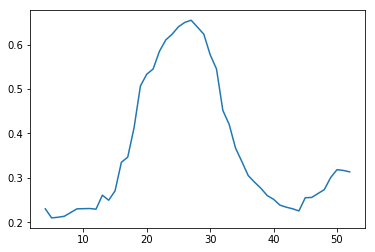

In [110]:
plot_culture_year(4, 2015)

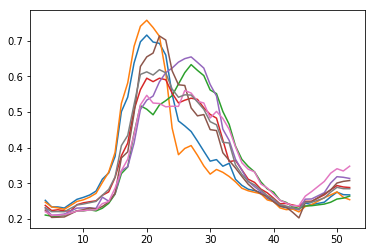

In [111]:
cult15 = df[df['year'] == 2015]['culture'].unique()

for cult in cult15:
    plot_culture_year(cult, 2015)

## Predicting that NDVI

In [112]:
weeks = [i + 1 for i in range(52)]

def plot_ndvi(culture, model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    
    cult_df = pd.DataFrame({
        'culture': [culture for _ in range(len(weeks))],
        'week': weeks
    })

    ndvi = model.predict(cult_df)
    plt.plot(weeks, ndvi)
    
    return r2

In [113]:
def plot_all_ndvi(model):
    scores = []
    for cult in X_test['culture'].unique():
        r2 = plot_ndvi(cult, model)
        scores.append(r2)
        
    print('r2_score:', np.array(scores).mean())

r2_score: -0.168651420113


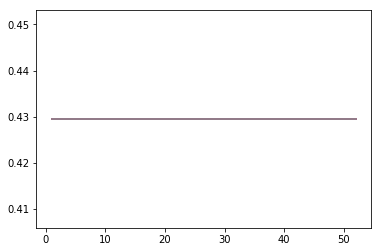

In [114]:
plot_all_ndvi(DummyRegressor())

r2_score: 0.557883466401


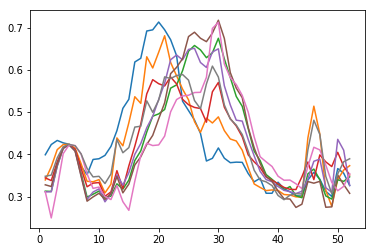

In [115]:
plot_all_ndvi(SVR())

r2_score: 0.488896198482


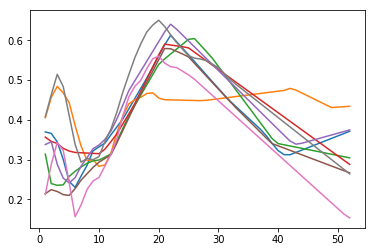

In [116]:
plot_all_ndvi(MLPRegressor())

In [122]:
def plot_ridge(degree):
    model = make_pipeline(PolynomialFeatures(degree), Ridge())
    plot_all_ndvi(model)

r2_score: 0.379120285035


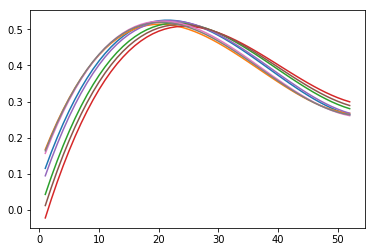

In [125]:
plot_ridge(degree=3)

r2_score: 0.529042530555


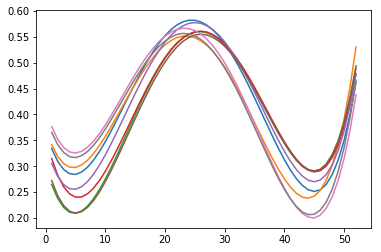

In [118]:
plot_ridge(degree=4)

r2_score: 0.604678078977


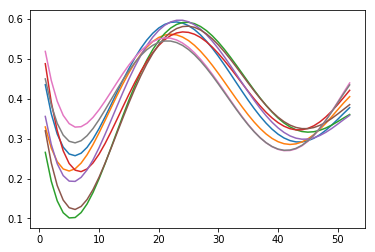

In [126]:
plot_ridge(degree=5)

r2_score: 0.617012574918


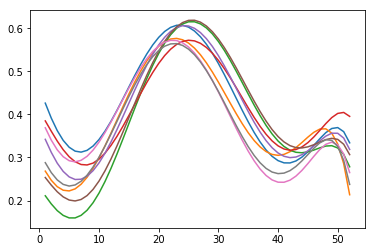

In [127]:
plot_ridge(degree=6)

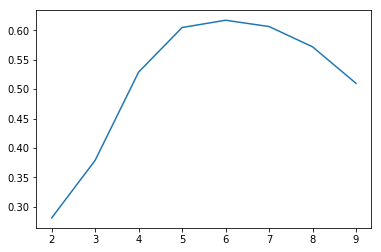

In [141]:
r2s = []
degrees = [2, 3, 4, 5, 6, 7, 8, 9]

for degree in degrees:
    model = make_pipeline(PolynomialFeatures(degree), Ridge())
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    r2s.append(r2)
    
plt.plot(degrees, r2s)